In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



# -----------------------------
# Load dataset first
# -----------------------------
df = pd.read_csv("datasets/SAMPLE_yellow_tripdata_2025-01.csv", low_memory=False)

# Basic filtering for valid values
df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['tip_amount'] >= 0)]

# Columns to standardize
cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']

# -----------------------------
# Standardize numeric columns
# -----------------------------
z_df = df[cols].apply(zscore)

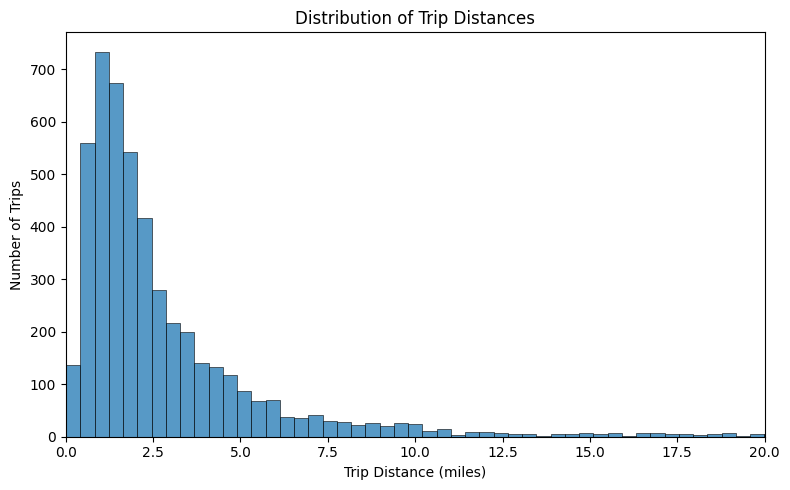

In [2]:
# 1. Histogram of trip distances

plt.figure(figsize=(8,5))
sns.histplot(df['trip_distance'], bins=100, kde=False)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Number of Trips')
plt.xlim(0, 20)  # limit to reduce effect of extreme outliers
plt.tight_layout()
plt.show()

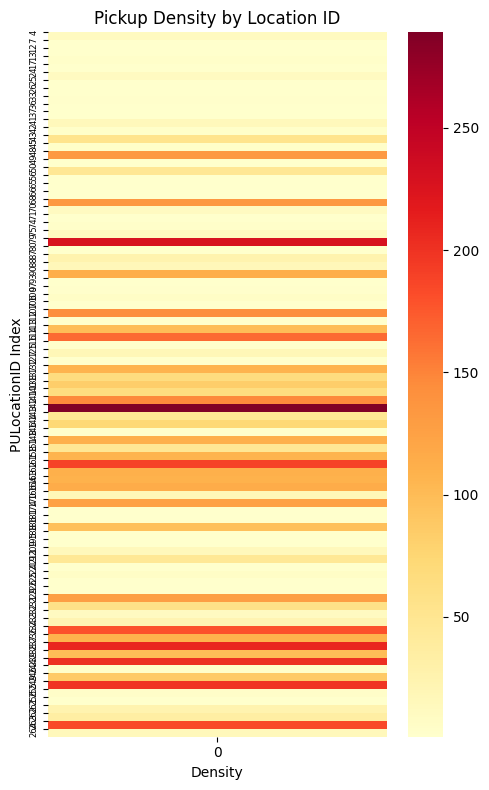

In [3]:
# 2. Heatmap of pickup density by Location ID

pickup_counts = df['PULocationID'].value_counts().sort_index()
plt.figure(figsize=(5,8))
sns.heatmap(pickup_counts.values.reshape(-1,1), cmap='YlOrRd', cbar=True)
plt.title('Pickup Density by Location ID')
plt.xlabel('Density')
plt.ylabel('PULocationID Index')
plt.yticks(
    range(len(pickup_counts.index)), 
    pickup_counts.index, 
    fontsize=6
)
plt.tight_layout()
plt.show()

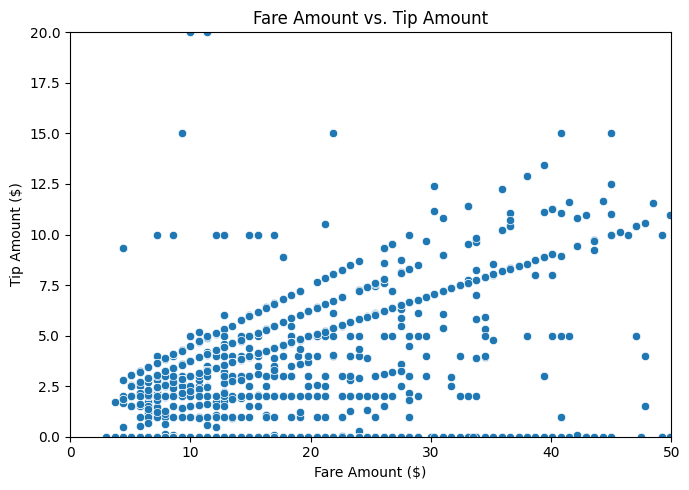

In [4]:
# 3. Scatter plot of fare amount vs. tip amount

plt.figure(figsize=(7,5))
sns.scatterplot(x='fare_amount', y='tip_amount', data=df.sample(2000, random_state=0))
plt.title('Fare Amount vs. Tip Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Tip Amount ($)')
plt.xlim(0, 50)
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

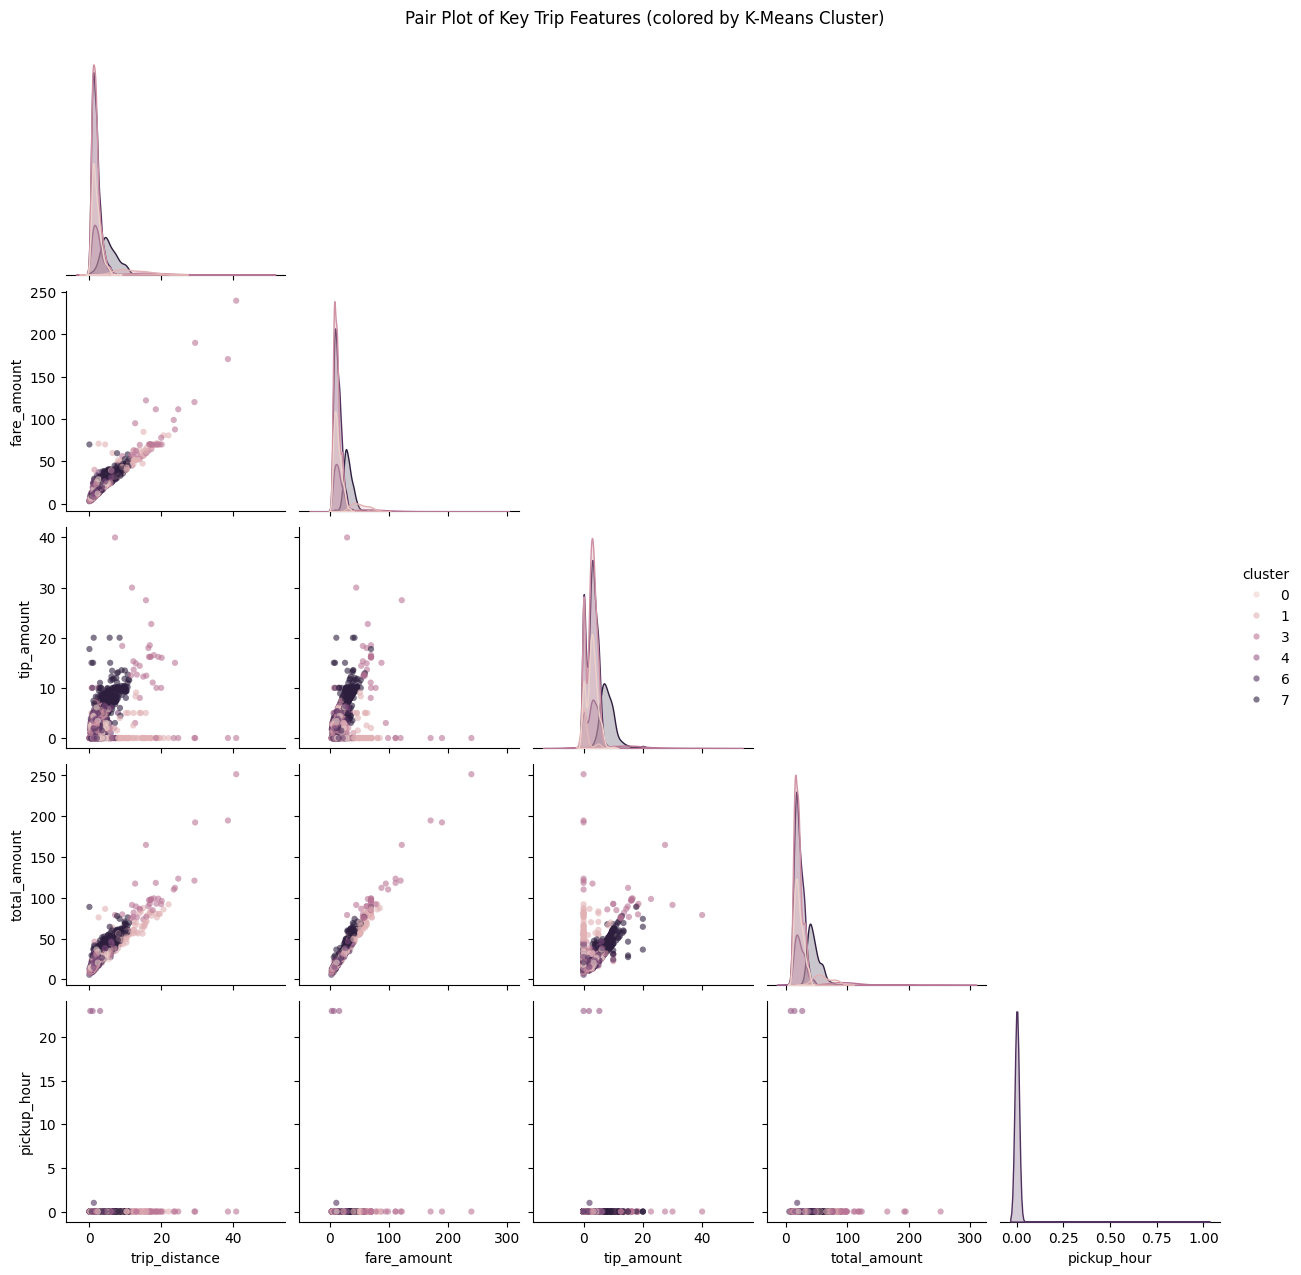

In [5]:
# Ensure required features exist

if 'tpep_pickup_datetime' in df and 'pickup_hour' not in df:
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
    df = df.dropna(subset=['tpep_pickup_datetime'])
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

if 'pickup_weekday' not in df and 'tpep_pickup_datetime' in df:
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday

cols = ['passenger_count','trip_distance','fare_amount','tip_amount',
        'total_amount','PULocationID','DOLocationID','pickup_hour','pickup_weekday']

# 2) Recompute clusters if missing
if 'cluster' not in df.columns:
    X = df[cols].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=8, n_init='auto', random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    df = df.loc[X.index].copy()
    df['cluster'] = labels

# 3) Pair plot
import seaborn as sns
import matplotlib.pyplot as plt

sample_df = df.sample(min(2000, len(df)))

pairplot_features = ['trip_distance','fare_amount','tip_amount','total_amount','pickup_hour']

g = sns.pairplot(
    sample_df,
    vars=pairplot_features,
    hue='cluster',
    corner=True,
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
)
g.fig.suptitle("Pair Plot of Key Trip Features (colored by K-Means Cluster)", y=1.02)
plt.show()


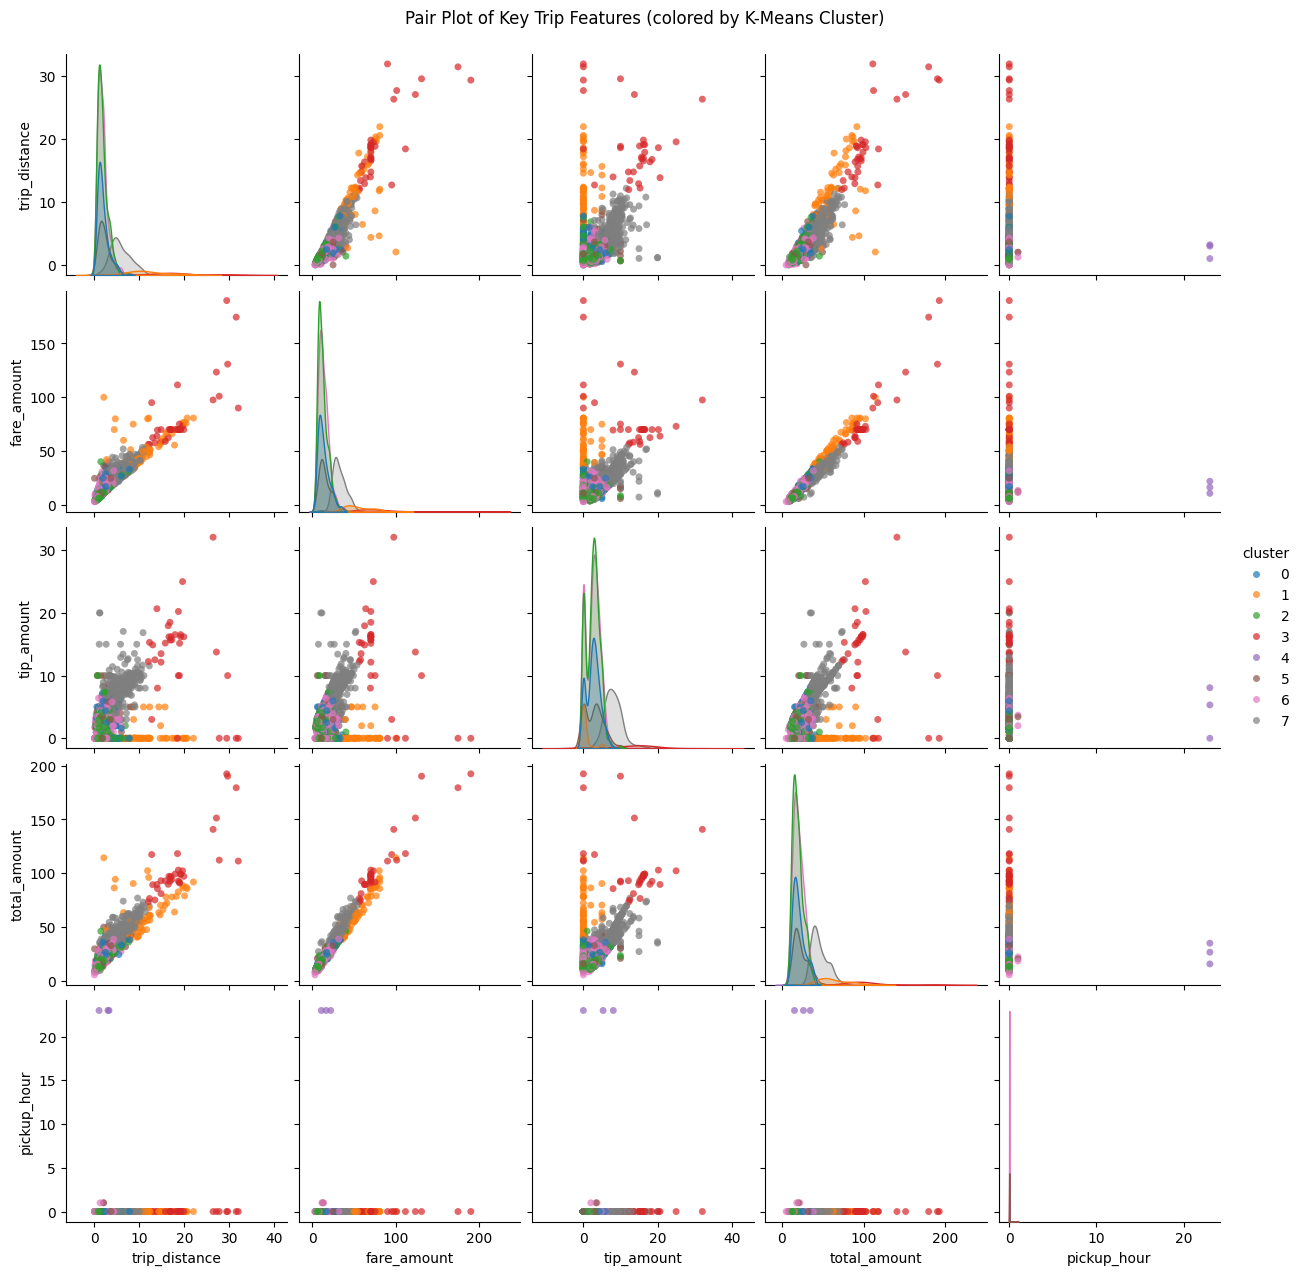

In [6]:
# Sample subset for visualization
sample_df = df.sample(min(2000, len(df)))

# Select numeric features to plot
pairplot_features = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'pickup_hour']

# Match palette to actual number of clusters
num_clusters = sample_df['cluster'].nunique()

# Create pair plot
sns.pairplot(
    sample_df,
    vars=pairplot_features,
    hue='cluster',
    palette=sns.color_palette("tab10", num_clusters),  # match number of clusters
    plot_kws={'alpha': 0.7, 's': 25, 'edgecolor': 'none'}
)

plt.suptitle("Pair Plot of Key Trip Features (colored by K-Means Cluster)", y=1.02)
plt.show()

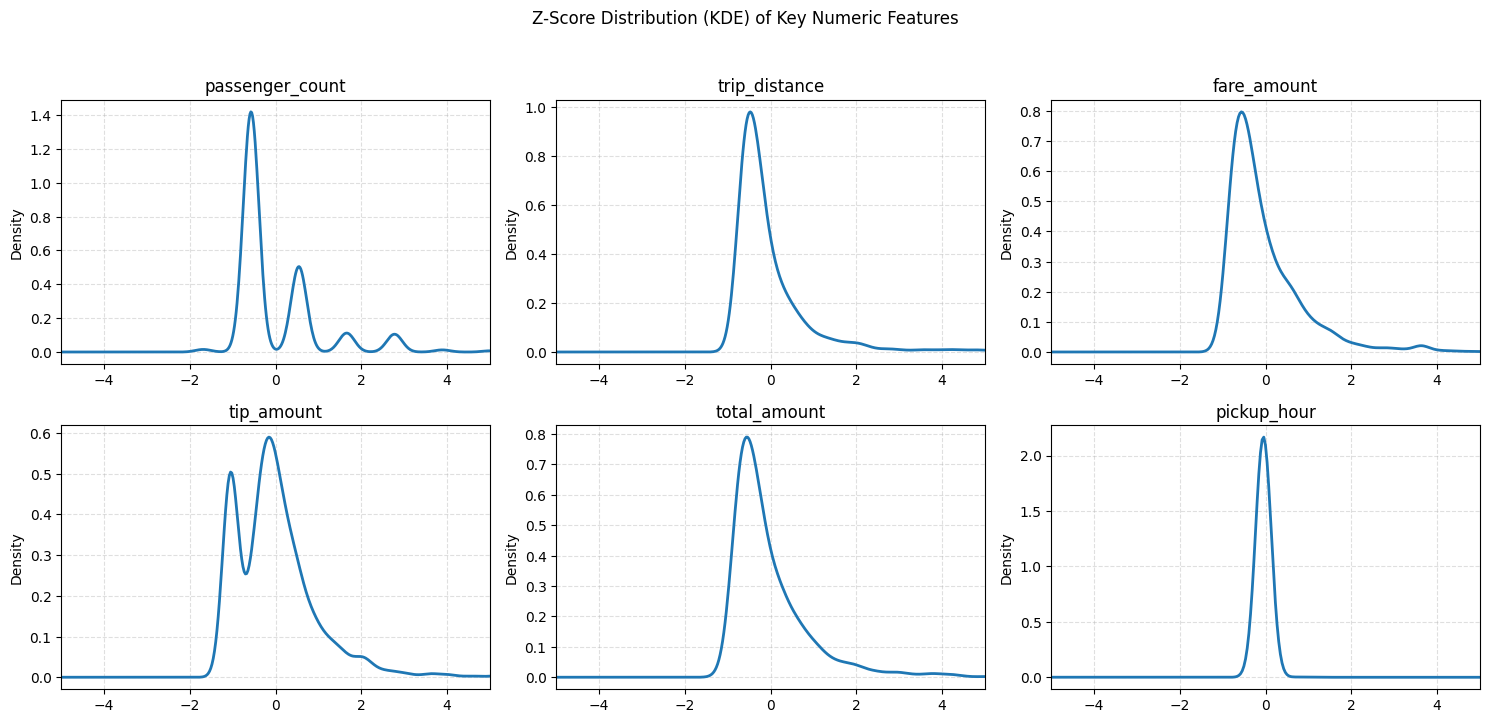

In [7]:
plot_cols = ['passenger_count','trip_distance','fare_amount',
             'tip_amount','total_amount']   # removed tpep_pickup_datetime

df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour

plot_cols = ['passenger_count','trip_distance','fare_amount',
             'tip_amount','total_amount','pickup_hour']

z_df = df[plot_cols].apply(zscore)

fig, axes = plt.subplots(len(plot_cols)//3 + 1, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(plot_cols):
    z_df[col].plot(kind='kde', linewidth=2, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlim(-5, 5)
    axes[i].grid(True, linestyle='--', alpha=0.4)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Z-Score Distribution (KDE) of Key Numeric Features", y=1.02)
plt.tight_layout()
plt.show()